# Studium przypadku - Prognozowanie wyniku partii szachowych

Autor: Mikołaj Nowak 151813

Źródło: https://lichess.org/api/games/user/tarask2000?tags=true&clocks=true&evals=false&opening=true&literate=false&perfType=ultraBullet%2Cbullet%2Cblitz%2Crapid%2Cclassical%2Ccorrespondence%2Cstandard


# Wymagania

Studium ma mieć postać raportu (pdf) z wynikami (wartości, tabele, wykresy...) i wnioskami z nich płynącymi. Zakres analizy musi być oryginalny, tzn. nie może pokrywać się z innymi pracami znanymi autorowi dotyczącymi wybranego zbioru. Nie trzeba zamieszczać w raporcie fragmentów kodu, ale trzeba dokładnie napisać jakich narzędzi/pakietów/źródeł używano, i oczywiście szczegółowo jakich algorytmów i parametrów.

Co najmniej trzy algorytmy uczenia maszynowego na osobę. Jeśli więcej niż jedna osoba analizuje ten sam zbiór danych, każda osoba niezależnie i samodzielnie wykorzystuje co najmniej trzy metody analizy – inne, niż wybrały pozostałe osoby.

Szczegółowy opis wybranego zbioru danych i jego charakterystyki; przykłady przypadków ze zbioru danych i interpretacja atrybutów. Cel: wykrycie w zbiorze danych wszystkich ciekawych zależności i własności. W tym celu samodzielny wybór technik wedle nabytej wiedzy dotyczącej uczenia maszynowego. Interpretacja (na ile jest możliwa) wyindukowanej przez algorytmy wiedzy.

# Opis użytych bibliotek

- **`pandas`** – do tworzenia i przetwarzania danych tabelarycznych (`DataFrame`), np. kolumn z wynikami partii, cechami graczy itp.
- **`numpy`** – do operacji na tablicach i danych liczbowych, np. przy obliczeniach statystycznych.
- **`collections.Counter`** – do pomocy przy zliczaniu obiektów przy estymacji rozkładów atrybutów.
- **`datetime`** – do obsługi dat i czasu, np. ekstrakcja dnia tygodnia lub godziny rozpoczęcia partii.
- **`chess.pgn`** *(z `python-chess`)* – do parsowania partii zapisanych w formacie PGN (Portable Game Notation).
- **`chess.svg` + `IPython.display`** (`SVG`, `display`) – do wizualizacji pozycji szachowych w formacie SVG w notatnikach Jupyter.
- **`re`** – do pracy z wyrażeniami regularnymi, np. ekstrakcja konkretnych ruchów lub oznaczeń roszady.
- **`os`** – do operacji na plikach i ścieżkach (np. iteracja po folderach z plikami PGN).
- **`matplotlib`** – do tworzenia wykresów (np. słupkowych, rozrzutu, heatmap).
- **`seaborn`** – do bardziej zaawansowanej wizualizacji danych (np. macierze korelacji, rozkłady).
- **`scipy`** – do testów statystycznych i analizy korelacji (testy nieparametryczne, Cramér’s V itp.).
- **`scikit-learn` (`sklearn`)** – do:
  - kodowania danych kategorycznych: `OneHotEncoder`
  - skalowania danych liczbowych: `StandardScaler`
  - transformacji kolumn: `ColumnTransformer`
  - tworzenia pipeline’ów: `Pipeline`
  - podziału zbioru: `train_test_split`
  - trenowania modeli: `LogisticRegression`, `RandomForestClassifier`
  - metryk ewaluacyjnych: `accuracy_score`, `mean_squared_error`, `r2_score`
- **`catboost`** – gradient boosting z natywną obsługą danych kategorycznych: `CatBoostClassifier`, `CatBoostRegressor`, `Pool`.
- **`shap`** – do interpretacji modelu i analizy wpływu cech (`TreeExplainer`, `force_plot`).
- **`imblearn`** – do balansu klas i oversamplingu, np. `SMOTE` dla nierównomiernie rozłożonych wyników.

In [1]:
import chess.pgn
import chess.svg
from IPython.display import SVG, display
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency, pearsonr, kruskal

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

# Opis zbioru danych

Zbiór danych zawiera metainformacje na temat **moich partii szachowych** (użytkownik `tarask2000`) pobranych z portalu [Lichess.org](https://www.lichess.org/). Zbiór zawiera **9960 partii** i ma na celu analizę moich rozgrywek, identyfikację wzorców (np. najczęściej grane debiuty, typowe godziny grania, wyniki w zależności od tempa, koloru itp.) oraz potencjalną predykcję wyników.

Każdy wiersz reprezentuje jedną partię i zawiera następujące kolumny:

- `color` – kolor figur gracza `tarask2000`: `"white"` lub `"black"`
- `rating_diff` – różnica rankingów (mój ranking minus ranking przeciwnika)
- `opponent_title` – tytuł szachowy przeciwnika (np. `"FM"`), `None` jeśli przeciwnik nie posiada tytułu
- `date` – data rozegrania partii (format `YYYY-MM-DD`)
- `weekday` – dzień tygodnia, w którym rozegrano partię (np. `"Monday"`)
- `hour` – godzina i minuta rozpoczęcia partii (format `HH:MM`)
- `time_control` – główny czas gry (w sekundach, np. `300` oznacza 5 minut)
- `increment` – czy partia miała inkrementację czasu (wartość logiczna: `True` jeśli był dodatek czasu, `False` jeśli nie)
- `termination` – sposób zakończenia partii:
  - `"Normal"` – zakończona standardowo (mat, remis)
  - `"Time forfeit"` – przeciwnik lub ja przekroczyliśmy czas
  - `"Abandoned"` – jedna ze stron porzuciła partię
  - `"Rules infraction"` – złamanie zasad gry
- `opening` – przypisany debiut (na podstawie kodu ECO zmapowanego do nazw debiutów, np. `"Sicilian"`, `"Reti"`, `"Spanish"` itd.)
- `result` – wynik z mojego punktu widzenia:
  - `1` – wygrana
  - `0` – przegrana
  - `0.5` – remis
- `my_castle` – typ roszady wykonanej przeze mnie:
  - `"kingside"` – krótka roszada
  - `"queenside"` – długa roszada
  - `"none"` – brak roszady
- `opponent_castle` – typ roszady wykonanej przez przeciwnika:
  - `"kingside"` – krótka roszada
  - `"queenside"` – długa roszada
  - `"none"` – brak roszady


In [2]:
def map_eco_to_opening(eco):
    if not eco or len(eco) < 3:
        return "Piece Odds"
    try:
        letter = eco[0]
        number = int(eco[1:])
    except:
        return None

    if (letter == "A" and number in range(0, 2)) or \
       (letter == "B" and number in range(0, 6)) or \
       (eco == "E00"):
        return "Irregular"

    if letter == "A" and number in range(2, 4):
        return "Bird"
    if letter == "A" and number in range(4, 10):
        return "Reti"
    if letter == "A" and number in range(10, 40):
        return "English"
    if (letter == "A" and number in [40, 41]) or (letter == "A" and number in range(45, 56)) or (letter == "E" and number in range(10, 20)):
        return "Queens Indian"
    if (eco == "A42") or (letter == "B" and number in range(6, 10)):
        return "Modern"
    if (letter == "A" and number in range(43, 45)) or (letter == "A" and number in range(56, 80)):
        return "Benoni"
    if letter == "A" and number in range(80, 100):
        return "Dutch"
    if letter == "B" and number in range(10, 20):
        return "Caro-Kann"
    if letter == "B" and number in range(20, 100):
        return "Sicilian"
    if letter == "C" and number in range(0, 20):
        return "French"
    if letter == "C" and number in range(20, 50):
        return "Irregular 1.e4"
    if letter == "C" and number in range(50, 60):
        return "Italian"
    if letter == "C" and number in range(60, 100):
        return "Spanish"
    if letter == "D" and number in range(0, 70):
        return "Queens Gambit"
    if letter == "D" and number in range(70, 100):
        return "Grunfeld"
    if letter == "E" and number in range(1, 10):
        return "Catalan"
    if letter == "E" and number in range(20, 60):
        return "Nimzo"
    if letter == "E" and number in range(60, 100):
        return "Kings Indian"
    return None

In [3]:
def get_castle_type(move_uci):
    if move_uci in ["e1g1", "e8g8"]:
        return "kingside"
    elif move_uci in ["e1c1", "e8c8"]:
        return "queenside"
    else:
        return None

In [4]:
def time_to_decimal(t):
    h, m = map(int, t.split(':'))
    return h + m / 60

In [5]:
def load_games_data(pgn_filename, my_username):
    games_data = []

    with open(pgn_filename, encoding="utf-8") as pgn:
        while True:
            game = chess.pgn.read_game(pgn)
            if game is None:
                break

            headers = game.headers
            white = headers.get("White", "").lower()
            black = headers.get("Black", "").lower()

            if white == my_username.lower():
                my_elo_str = headers.get("WhiteElo", "0")
                opponent_elo_str = headers.get("BlackElo", "0")
                if not (my_elo_str.isdigit() and opponent_elo_str.isdigit()):
                    continue
                color = "white"
                my_elo = int(my_elo_str)
                opponent_elo = int(opponent_elo_str)
                opponent_title = headers.get("BlackTitle", "None")
                result_str = headers.get("Result", "")
                my_color = "white"
            elif black == my_username.lower():
                my_elo_str = headers.get("BlackElo", "0")
                opponent_elo_str = headers.get("WhiteElo", "0")
                if not (my_elo_str.isdigit() and opponent_elo_str.isdigit()):
                    continue
                color = "black"
                my_elo = int(my_elo_str)
                opponent_elo = int(opponent_elo_str)
                opponent_title = headers.get("WhiteTitle", "None")
                result_str = headers.get("Result", "")
                my_color = "black"
            else:
                continue

            rating_diff = my_elo - opponent_elo

            date_str = headers.get("UTCDate", None)
            time_str = headers.get("UTCTime", None)
            try:
                dt = datetime.strptime(f"{date_str} {time_str}", "%Y.%m.%d %H:%M:%S")
                time = dt.strftime("%H:%M")
                weekday = dt.strftime("%A")
            except:
                time = None
                weekday = None

            tc = headers.get("TimeControl", "")
            if "+" in tc:
                base, inc = tc.split("+")
                try:
                    base_time = int(base)
                    increment = int(inc) > 0
                except:
                    base_time = None
                    increment = None
            else:
                base_time = None
                increment = None

            eco = headers.get("ECO", None)

            if (color == "white" and result_str == "1-0") or (color == "black" and result_str == "0-1"):
                result = 1
            elif result_str == "1/2-1/2":
                result = 0.5
            else:
                result = 0

            my_castle = "None"
            opponent_castle = "None"

            moves = list(game.mainline_moves())
            for i, move in enumerate(moves):
                move_uci = move.uci()
                castle_type = get_castle_type(move_uci)
                if castle_type:
                    move_number = i + 1
                    if my_color == "white":
                        if move_number % 2 == 1:
                            my_castle = castle_type
                        else:
                            opponent_castle = castle_type
                    else:
                        if move_number % 2 == 0:
                            my_castle = castle_type
                        else:
                            opponent_castle = castle_type

            termination = headers.get("Termination", None)

            games_data.append({
                "color": color,
                "rating_diff": rating_diff,
                "opponent_title": opponent_title,
                "time": time,
                "weekday": weekday,
                "base_time": base_time,
                "increment": increment,
                "opening": map_eco_to_opening(eco),
                "result": result,
                "my_castle": my_castle,
                "opponent_castle": opponent_castle,
                "termination": termination
            })

    df = pd.DataFrame(games_data)
    return df

In [6]:
MY_USERNAME = "tarask2000"
PGN_FILENAME = "lichess_tarask2000_2025-05-31.pgn"
df = load_games_data(my_username=MY_USERNAME, pgn_filename=PGN_FILENAME)

# Wstępne przetwarzanie danych

In [7]:
print(df.head())

   color  rating_diff opponent_title   time weekday  base_time  increment    opening  result my_castle opponent_castle   termination
0  white          183           None  16:49  Friday         60      False    English     1.0  kingside        kingside  Time forfeit
1  black           77             FM  16:47  Friday         60      False  Irregular     1.0  kingside        kingside        Normal
2  white          194           None  16:45  Friday         60      False    English     1.0  kingside        kingside        Normal
3  white            7           None  16:43  Friday         60      False    English     1.0      None        kingside        Normal
4  black          153             IM  16:42  Friday         60      False     Benoni     1.0  kingside        kingside        Normal


### Opis przykładowej obserwacji

Pierwsza z pięciu ostatnich partii została rozegrana kolorem białym w piątek o godzinie 16:49. Mój przeciwnik nie posiadał tytułu szachowego i miał ranking niższy o 183 punkty. Tempo gry wynosiło 60 sekund bez inkrementu. Gra została przeze mnie wygrana na czas. Debiutem była Partia angielska (English), a zarówno ja, jak i przeciwnik wykonaliśmy krótką roszadę.

Ostatnie 5 partii rozegrałem w piątek między 16:42 a 16:49, wszystkie w tempie jednej minuty bez inkrementu i wszystkie zakończone moją wygraną. Trzy z nich grałem kolorem białym, dwie czarnym. Partie, w których grałem białymi, rozpoczęły się debiutem angielskim — co jest zgodne z tym, że grający białymi decyduje o otwarciu. Pozostałe debiuty to Benoni i nieregularny. Tylko dwóch przeciwników miało tytuły szachowe — FM i IM. W czterech partiach wykonałem krótką roszadę, a w jednej (białymi) nie zrobiłem żadnej.

Można też zwizualizować przebieg partii na szachownicy w kluczowych momentach, na przykład po pierwszych dwóch pełnych ruchach (czyli po posunięciu białego i czarnego), po 10 ruchach czy na końcu partii.

Po 2 ruchu:


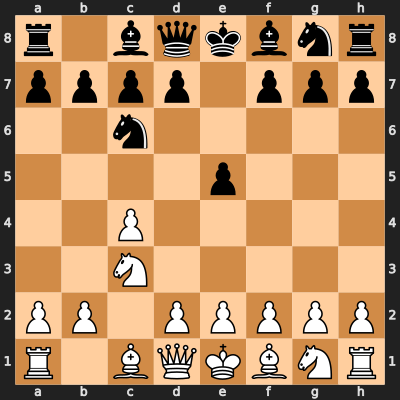

Po 10 ruchu:


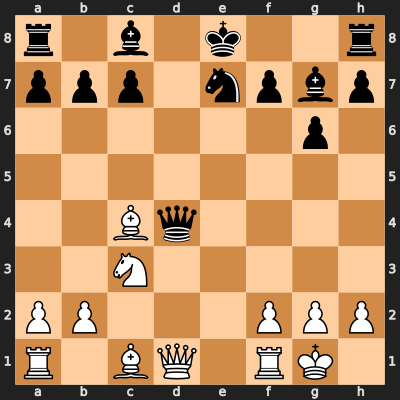

Pozycja końcowa:


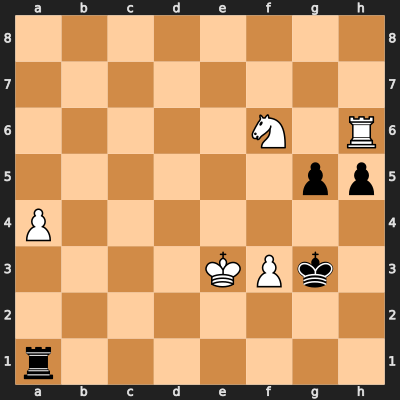

In [8]:
with open("lichess_tarask2000_2025-05-31.pgn", encoding="utf-8") as pgn:
    game = chess.pgn.read_game(pgn)

board = game.board()
positions_to_show = [4, 20]  # (halfmoves)
positions = {}

for i, move in enumerate(game.mainline_moves(), start=1):
    board.push(move)
    if i in positions_to_show:
        positions[i] = board.fen()

positions['final'] = board.fen()

for key, fen in positions.items():
    board.set_fen(fen)
    if isinstance(key, int):
        move_num = key // 2
        desc = f"Po {move_num} ruchu" if key % 2 == 0 else f"Po {move_num} ruchu (po posunięciu białych)"
    else:
        desc = "Pozycja końcowa"
    print(desc + ":")
    display(SVG(chess.svg.board(board=board, size=400)))


### Obsługa brakujących wartości

Przed dalszym przetwarzaniem danych należy sprawdzić, czy w zbiorze danych występują brakujące wartości

In [9]:
df.isnull().sum()

color              0
rating_diff        0
opponent_title     0
time               0
weekday            0
base_time          0
increment          0
opening            0
result             0
my_castle          0
opponent_castle    0
termination        0
dtype: int64

Wszystkie gry zostały zaimportowane poprawnie – żadna z kolumn w ramce danych nie zawiera brakujących wartości.


### Rozkład wartości w kolumnach kategorycznych

Aby lepiej zrozumieć strukturę danych, warto przeanalizować rozkłady częstości w kolumnach kategorycznych. Dzięki temu możemy zobaczyć np. jak często grano białymi, ilu przeciwników miało tytuły szachowe, które dni tygodnia dominują w grze, jak często występuje dany debiut lub jaka roszada jest częściej wykonywana.

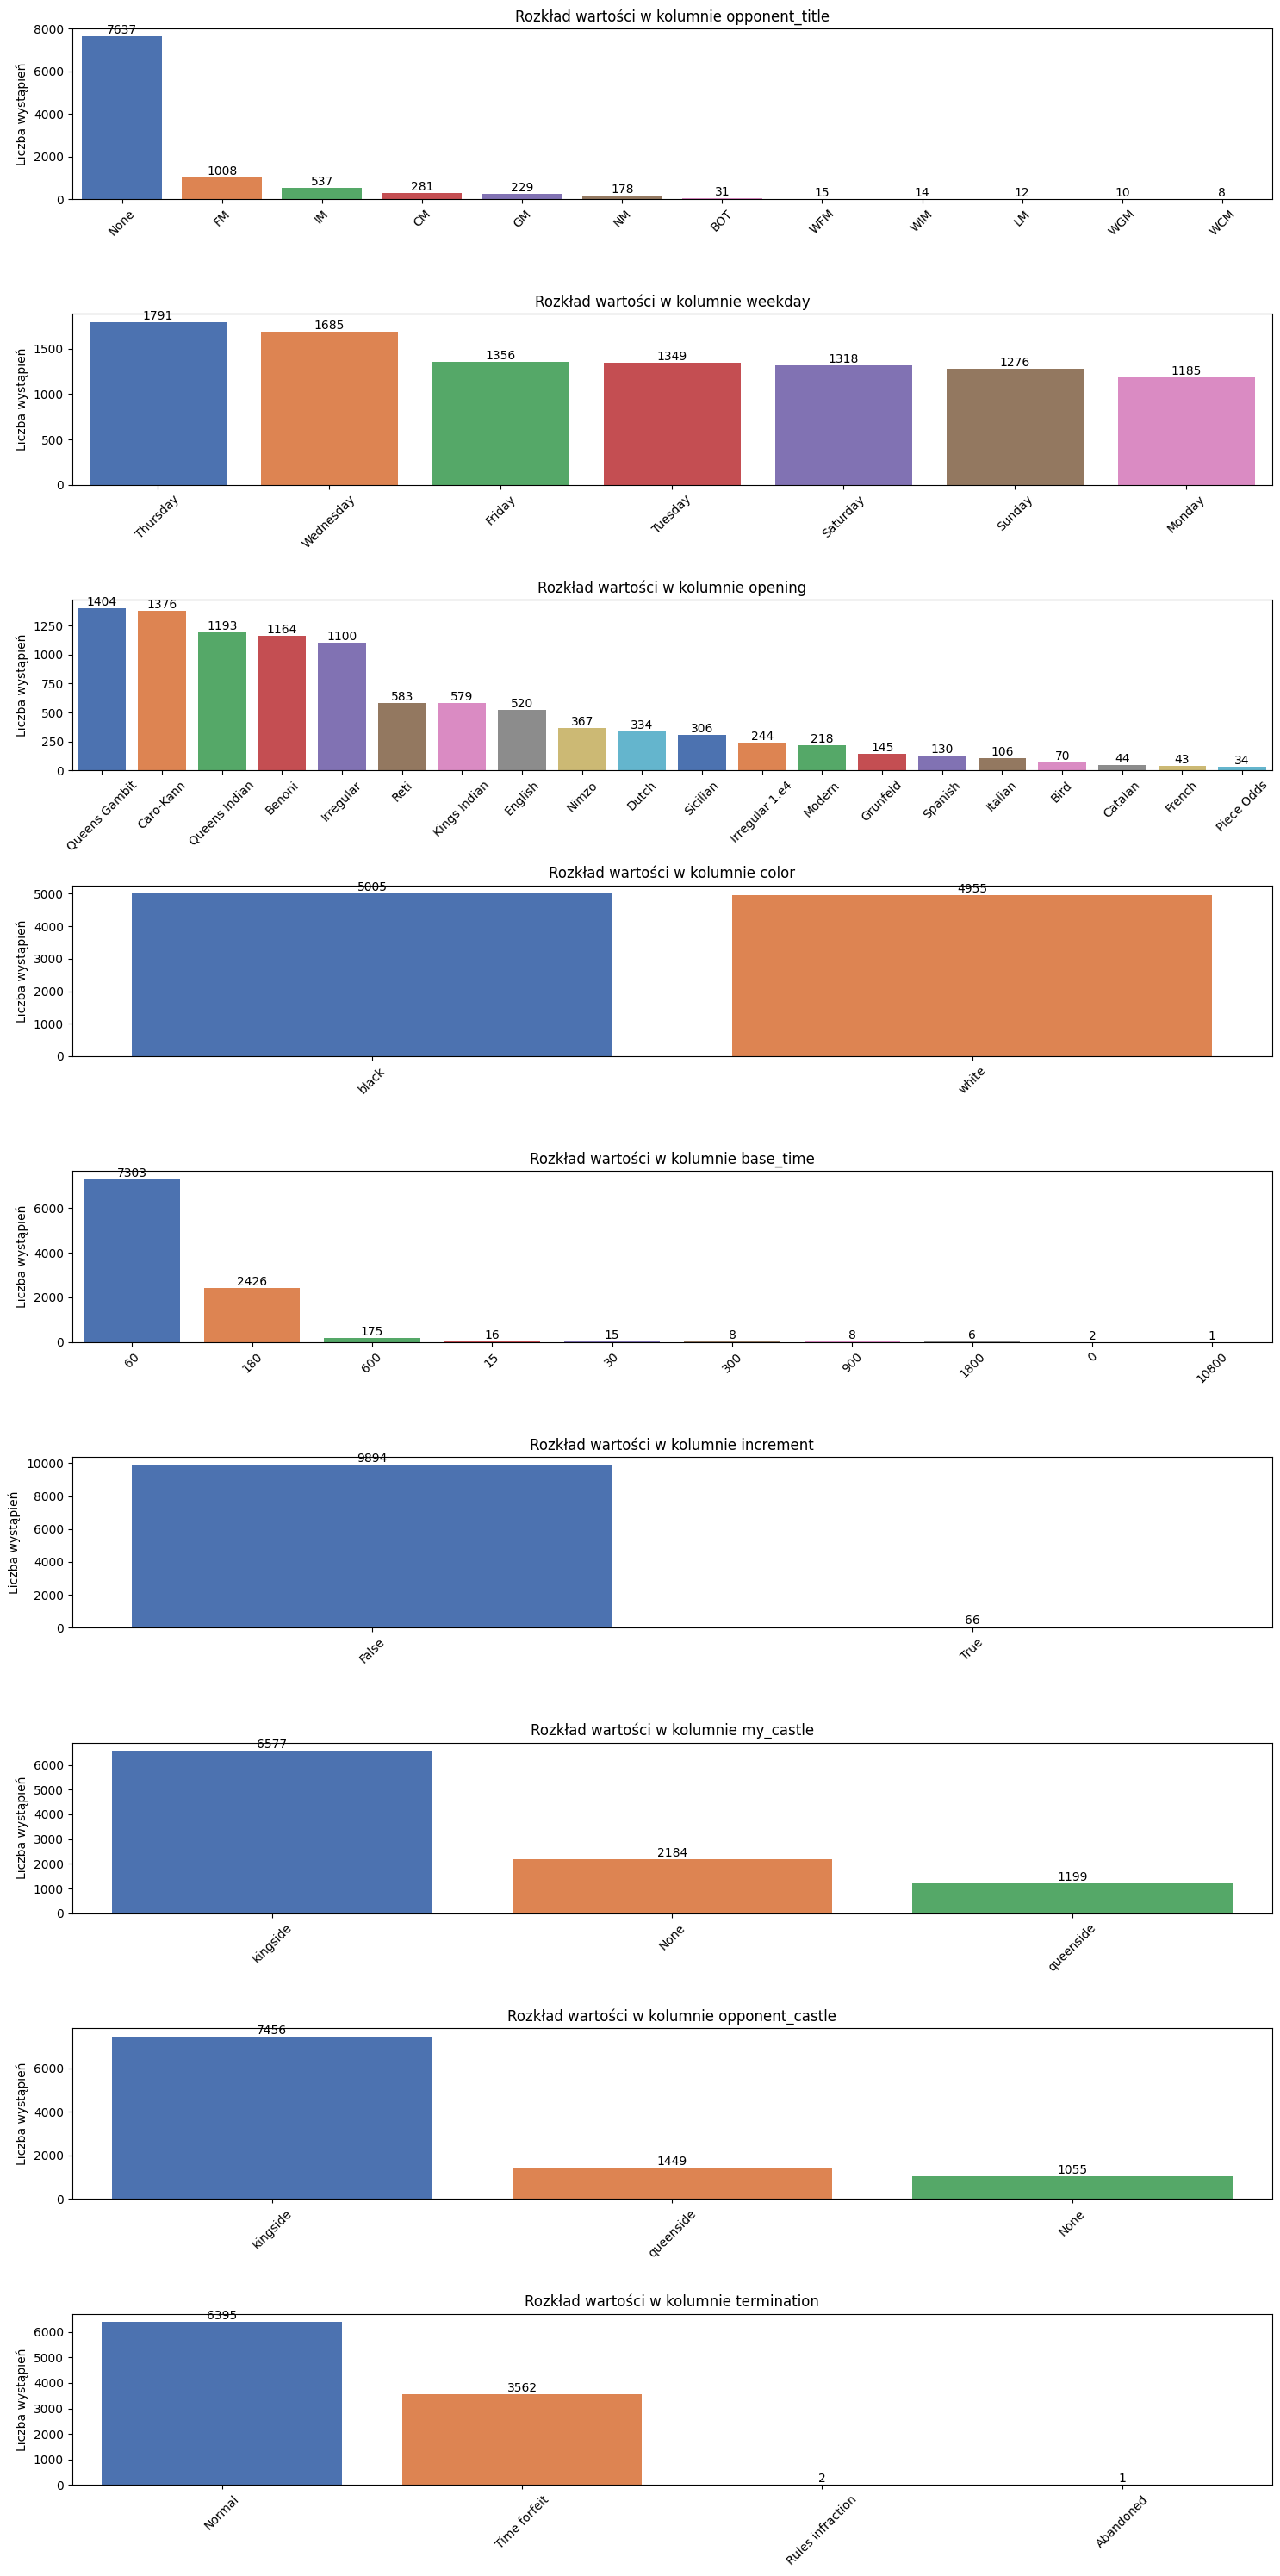

In [10]:
categorical_columns = [
    "opponent_title",
    "weekday",
    "opening",
    "color",
    "base_time",
    "increment",
    "my_castle",
    "opponent_castle",
    "termination"
]

palette = sns.color_palette("deep", 10)

plt.figure(figsize=(15, 30))

for i, col in enumerate(categorical_columns, 1):
    plt.subplot(len(categorical_columns), 1, i)
    
    order = df[col].value_counts().index
    
    ax = sns.countplot(data=df, x=col, order=order, color="lightgray")
    
    for j, patch in enumerate(ax.patches):
        color = palette[j % len(palette)]
        patch.set_facecolor(color)
        
        height = patch.get_height()
        ax.annotate(f'{int(height)}', 
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=10, color='black')
        
    plt.title(f"Rozkład wartości w kolumnie {col}")
    plt.xlabel("")
    plt.ylabel("Liczba wystąpień")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Rozkład wartości w kolumnach ciągłych

Aby lepiej zrozumieć strukturę danych, warto przeanalizować rozkłady wartości w kolumnach ciągłych. Pozwala to ocenić, czy zmienne są rozłożone równomiernie, czy też wykazują skośność, obecność wartości odstających lub inne cechy.

W szczególności:
- `rating_diff` informuje o różnicy rankingów między graczem a przeciwnikiem – to potencjalnie kluczowa zmienna, ponieważ większa różnica może świadczyć o nierównym poziomie graczy.
- `time` (przekształcone do formatu dziesiętnego) pozwala przeanalizować, o jakich porach najczęściej rozgrywane są partie, co może mieć związek z porą dnia i formą gracza.

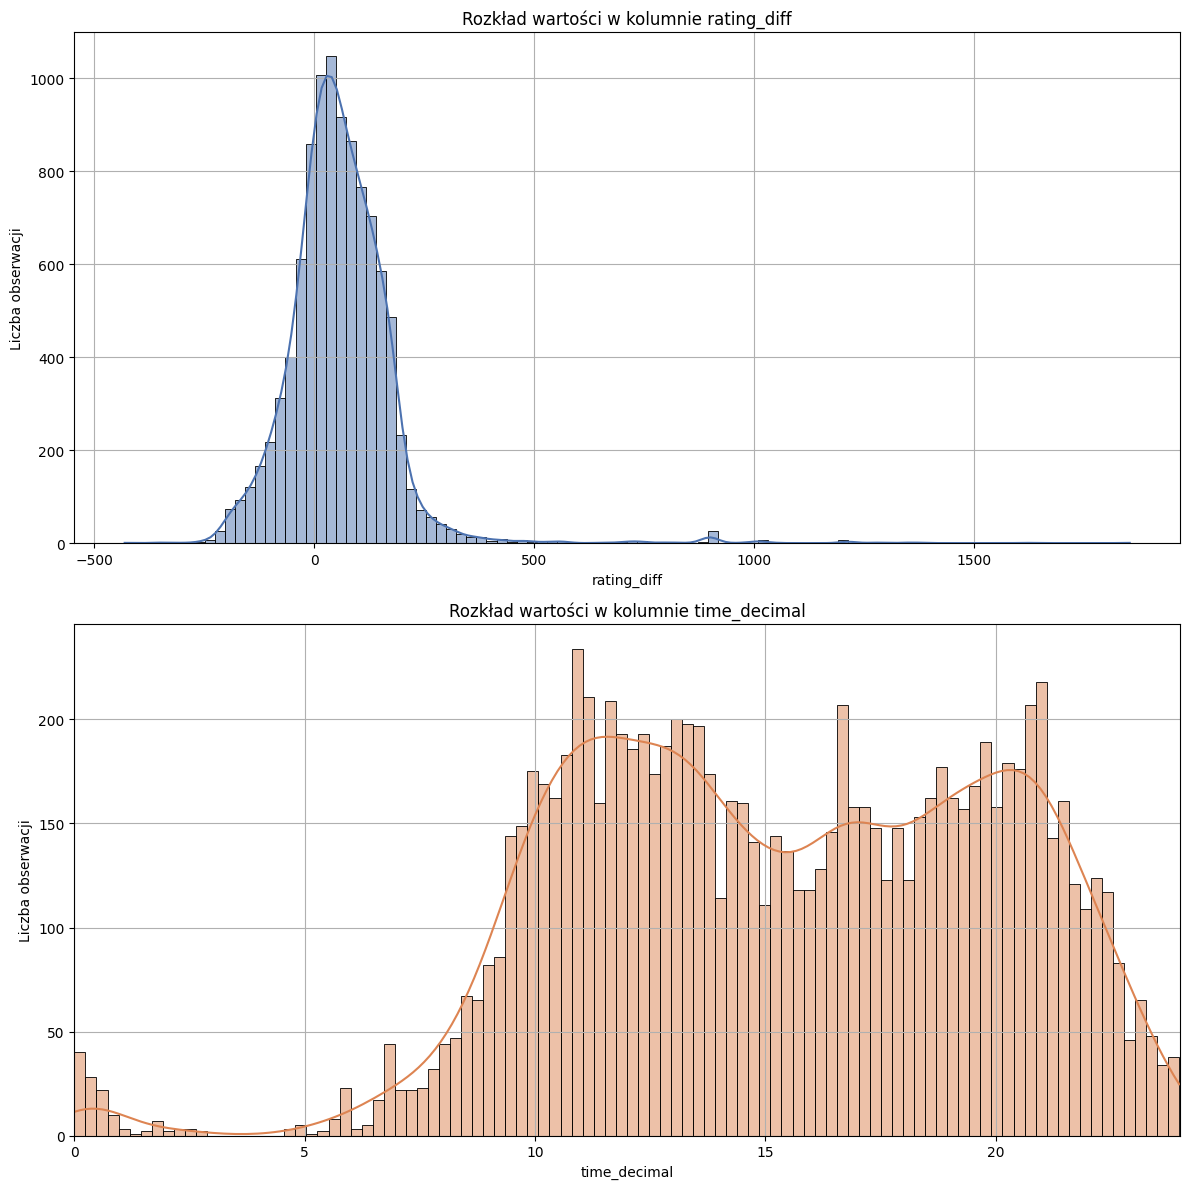

In [11]:
time_decimal = df['time'].apply(time_to_decimal)

continuous_columns = {
    "rating_diff": df["rating_diff"],
    "time_decimal": time_decimal
}

palette = sns.color_palette("deep", len(continuous_columns))

plt.figure(figsize=(12, 12))

for i, (col_name, series) in enumerate(continuous_columns.items(), 1):
    plt.subplot(len(continuous_columns), 1, i)
    
    sns.histplot(x=series, kde=True, bins=100, color=palette[i - 1])
    
    plt.title(f"Rozkład wartości w kolumnie {col_name}")
    plt.xlabel(col_name)
    if col_name == "time_decimal":
        plt.xlim(0, 24)
    plt.ylabel("Liczba obserwacji")
    plt.grid(True)

plt.tight_layout()
plt.show()

### Rozkład wartości w kolumnie decyzyjnej `result`

Kolumna `result` reprezentuje wynik partii szachowej i jest zmienną decyzyjną o trzech możliwych wartościach:
- `0` oznacza przegraną,
- `0.5` remis,
- `1` wygraną.




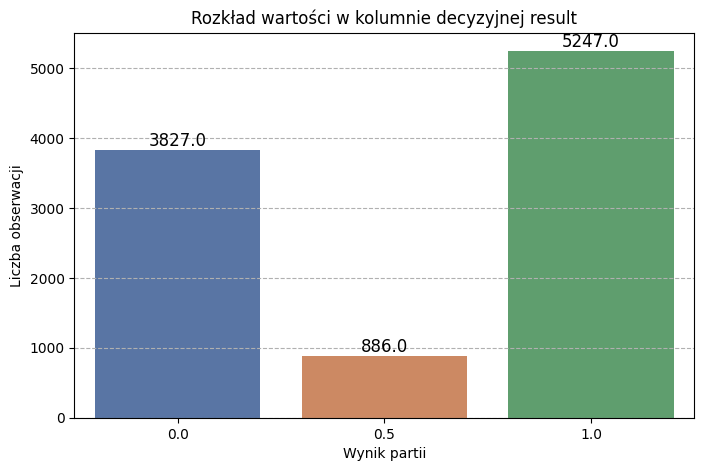

In [12]:
plt.figure(figsize=(8, 5))

ax = sns.countplot(x='result', data=df, hue='result', palette='deep', legend=False)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=12)

plt.title("Rozkład wartości w kolumnie decyzyjnej result")
plt.xlabel("Wynik partii")
plt.ylabel("Liczba obserwacji")
plt.grid(axis='y', linestyle='--')
plt.show()


### Czyszczenie danych

Dwia rodzaje wartości – `Abandoned` oraz `Rules infraction` – w kolumnie `termination` oznaczają partie niereprezentatywne:

- `Abandoned`: partia została porzucona i nie została dokończona,
- `Rules infraction`: najczęściej oznacza "violation", czyli naruszenie zasad — np. rozgrywki treningowe analizowane z uczniem lub z pomocą silnika, które zostały uznane przez system Lichessa za podejrzane i przerwane.

Takie partie nie odzwierciedlają rzeczywistej gry i powinny zostać usunięte ze zbioru. Po ich usunięciu pozostają jedynie partie zakończone normalnie (`Normal`) lub przez przekroczenie czasu (`Time forfeit`), co w praktyce tworzy binarny atrybut zakończenia partii: normalne vs. czas.

In [13]:
df = df[~df["termination"].isin(["Abandoned", "Rules infraction"])]

### Atrybuty cykliczne

Zmienna `time` reprezentuje godzinę dnia i ma charakter cykliczny. Aby uchwycić tę właściwość w modelu, można zakodować ją jako parę cech: sinus i cosinus przeskalowanej godziny.


In [14]:
def add_time_cyclic_features(df):
    df['time_decimal'] = df['time'].apply(time_to_decimal)
    df['time_sin'] = np.sin(2 * np.pi * df['time_decimal'] / 24)
    df['time_cos'] = np.cos(2 * np.pi * df['time_decimal'] / 24)
    df.drop(columns=['time', 'time_decimal'], inplace=True)

In [15]:
add_time_cyclic_features(df)

# 1. Szukanie zależności

In [16]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r - 1, k - 1))))

def kruskal_wallis_continuous_vs_categorical(continuous, categorical):
    groups = [continuous[categorical == cat] for cat in categorical.unique()]
    stat, p = kruskal(*groups)
    return stat, p

In [17]:
categorical_columns = [
    "opponent_title",
    "weekday",
    "opening",
    "color",
    "base_time",
    "increment",
    "my_castle",
    "opponent_castle",
    "termination",
]

continuous_columns = [
    "rating_diff",
    "time_sin",
    "time_cos",
]

target = "result"

### Macierz korelacji kolumn numerycznych (w tym atrybut decyzyjny `result`)

W poniższej macierzy przedstawiono współczynniki korelacji pomiędzy wszystkimi kolumnami numerycznymi w zbiorze danych, w tym kolumną decyzyjną `result`, która przyjmuje wartości `0` (przegrana), `0.5` (remis) i `1` (wygrana). Korelacja została policzona za pomocą współczynnika **Pearsona**, który mierzy liniową zależność pomiędzy zmiennymi.


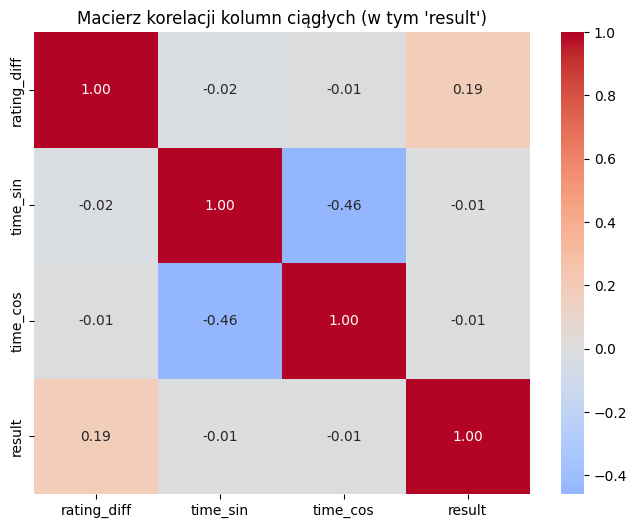

In [18]:
plt.figure(figsize=(8, 6))
corr_cont = df[continuous_columns + [target]].corr()
sns.heatmap(corr_cont, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Macierz korelacji kolumn ciągłych (w tym 'result')")
plt.show()

- Wysoka ujemna korelacja `-0.46` między `time_sin` i `time_cos` wynika z faktu, że są to **sztucznie wygenerowane kolumny** opisujące tę samą cechę (`time`) w postaci sinusoidalnej. To zachowanie jest **oczekiwane** i nie wskazuje na zależność przyczynowo-skutkową.

- Współczynnik korelacji `0.19` między `rating_diff` a `result` nie jest bardzo wysoki, ale może być **znaczący statystycznie**. Wskazuje, że im większa różnica rankingów na korzyść gracza, tym większe szanse na wygraną. Jednak:

  > Wiele partii rozegranych było z przeciwnikami o **zbliżonym rankingu**, co powoduje, że wartości `rating_diff` są skupione blisko zera, a wyniki rozgrywek są **rozłożone mniej więcej po równo** (wygrana/przegrana/remis). To może sprawiać, że zależność między `rating_diff` a `result` **nie układa się liniowo**.

W dalszej analizie warto zbadać tę relację za pomocą **regresji**, np. logistycznej lub nieliniowej, by lepiej zrozumieć wpływ rankingu na wynik partii.


### Macierz Cramér’s V dla kolumn kategorycznych (w tym `result`)

W poniższej macierzy przedstawiono siłę zależności pomiędzy wszystkimi kolumnami kategorycznymi, w tym kolumną decyzyjną `result`. Do oceny zależności między zmiennymi nominalnymi użyto statystyki **Cramér’s V**, która przyjmuje wartości od `0` (brak zależności) do `1` (pełna zależność)


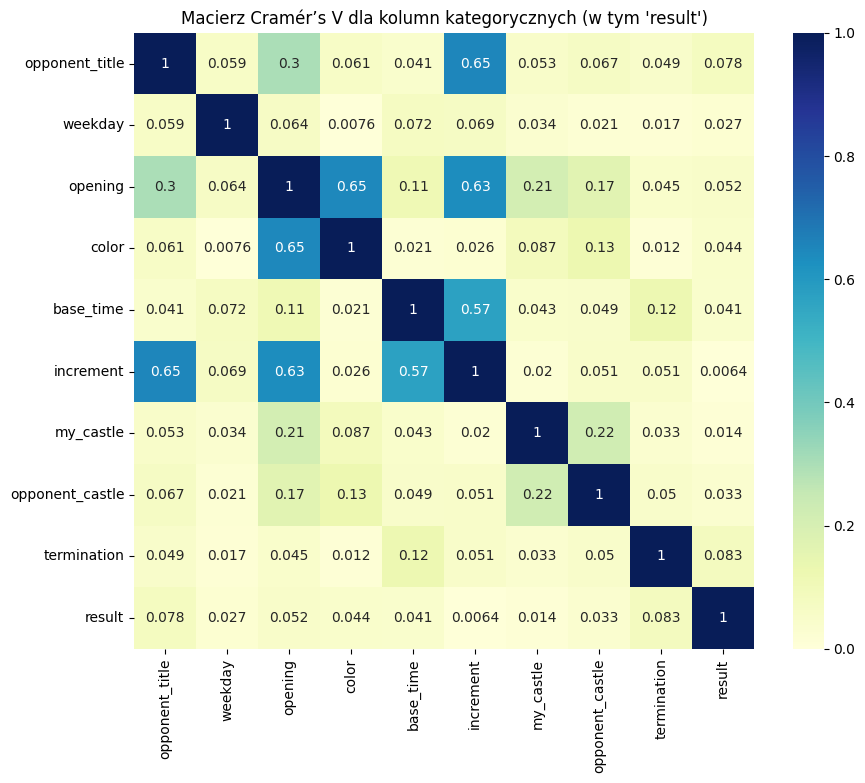

In [19]:
cat_cols_with_target = categorical_columns + [target]

plt.figure(figsize=(10, 8))
cramers_matrix = pd.DataFrame(index=cat_cols_with_target, columns=cat_cols_with_target)

for c1 in cat_cols_with_target:
    for c2 in cat_cols_with_target:
        if c1 == c2:
            cramers_matrix.loc[c1, c2] = 1.0
        else:
            cramers_matrix.loc[c1, c2] = cramers_v(df[c1], df[c2])

cramers_matrix = cramers_matrix.astype(float)
sns.heatmap(cramers_matrix, annot=True, cmap="YlGnBu", vmin=0, vmax=1)
plt.title("Macierz Cramér’s V dla kolumn kategorycznych (w tym 'result')")
plt.show()


- Żadna pojedyncza kolumna kategoryczna **nie wykazuje silnej zależności** z kolumną `result`, co oznacza, że wynik partii nie zależy wyraźnie od jednej konkretnej zmiennej kategorycznej. Wskazuje to, że predykcja wyniku wymaga uwzględnienia **kombinacji cech**, a nie tylko jednej z nich.

- Wysoka zależność pomiędzy `color` a `opening` jest logiczna – **niektóre debiuty wybieram częściej grając białymi**, a inne czarnymi. To odzwierciedla **preferencje debiutowe w zależności od koloru**.

- Zależność `opening` od `increment` również ma sens – przy różnych kontrolach czasu mogę preferować inne debiuty. Np. przy braku dodawanego czasu mogę grać **bardziej taktyczne warianty**, żeby szybciej zmusić przeciwnika do samodzielnego myślenia.

- Korelacja między `opening` a `opponent_title` jest już mniejsza, co też ma odzwierciedlenie w rzeczywistości – przeciwko utytułowanym przeciwnikom mogę grać **bardziej solidnie**, ale nie jest to reguła.

- Zmienna `my_castle` koreluje z `opponent_castle` oraz `opening`, co jest typowe – często **obie strony roszują w tym samym kierunku** zależnie od struktury pozycji.

- Widać też zależność między `base_time` a `termination`, co może wskazywać, że **krótsze czasy** powodują więcej partii kończących się **przegraną na czas**, zamiast poprzez matowanie.

Wszystkie te zależności mają **intuicyjne uzasadnienie**, ale wymagają dalszej analizy.

# 2. Klasyfikacja wartości `result` jako zmiennej kategorycznej

W tej sekcji potraktujemy kolumnę `result` jako zmienną kategoryczną przyjmującą trzy wartości:
- `0` – przegrana,
- `0.5` – remis,
- `1` – wygrana.

Celem jest zbudowanie modeli klasyfikacyjnych, które przewidują wynik partii na podstawie pozostałych cech.

Do analizy wykorzystano trzy algorytmy:
1. **Logistic Regression (multinomial)** – klasyczny model liniowy, który wymaga zakodowania cech kategorycznych (OneHotEncoding).
2. **Random Forest Classifier** – model zespołowy (ensemble), również wymagający kodowania cech.
3. **CatBoost Classifier** – nowoczesny model gradient boosting, który natywnie wspiera kolumny kategoryczne (bez potrzeby kodowania ręcznego).

Ponadto, dla porównania, zastosowano także:
4. **Losowy klasyfikator (Random Classifier)** – prosty klasyfikator przewidujący wyniki losowo według rozkładu klas w zbiorze treningowym. 

Zbiór danych podzielono na część treningową i testową (80/20), a jako metrykę wykorzystano dokładność klasyfikacji (`accuracy`).

Logistic Regression - Train Accuracy: 0.573, Test Accuracy: 0.572
Random Forest - Train Accuracy: 0.566, Test Accuracy: 0.571
CatBoost - Train Accuracy: 0.657, Test Accuracy: 0.560
Random classifier - Test Accuracy: 0.436


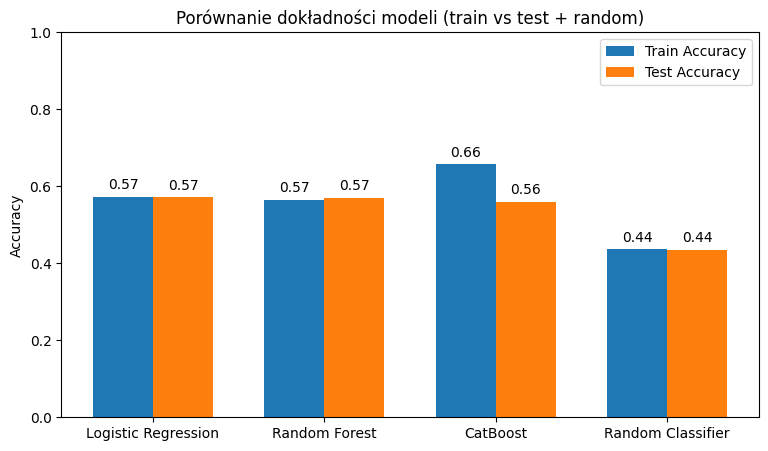

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from collections import Counter

X = df.drop(columns=["result"])
y = df["result"].astype("category").cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler

logistic_pipeline = Pipeline(steps=[
    ("preprocessor", ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_columns),
            ("num", StandardScaler(), [col for col in X.columns if col not in categorical_columns])
        ],
        remainder="drop"
    )),
    ("classifier", LogisticRegression(max_iter=2000))
])

logistic_pipeline.fit(X_train, y_train)
log_train_pred = logistic_pipeline.predict(X_train)
log_test_pred = logistic_pipeline.predict(X_test)
log_train_acc = accuracy_score(y_train, log_train_pred)
log_test_acc = accuracy_score(y_test, log_test_pred)
print(f"Logistic Regression - Train Accuracy: {log_train_acc:.3f}, Test Accuracy: {log_test_acc:.3f}")

rf_pipeline = Pipeline(steps=[
    ("preprocessor", ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_columns)
        ],
        remainder="passthrough"
    )),
    ("classifier", RandomForestClassifier(
        random_state=42,
        max_depth=5,
        min_samples_leaf=5
    ))
])

rf_pipeline.fit(X_train, y_train)
rf_train_pred = rf_pipeline.predict(X_train)
rf_test_pred = rf_pipeline.predict(X_test)
rf_train_acc = accuracy_score(y_train, rf_train_pred)
rf_test_acc = accuracy_score(y_test, rf_test_pred)
print(f"Random Forest - Train Accuracy: {rf_train_acc:.3f}, Test Accuracy: {rf_test_acc:.3f}")

cat_features_indices = [X.columns.get_loc(col) for col in categorical_columns]

cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_train, y_train, cat_features=cat_features_indices)
cat_train_pred = cat_model.predict(X_train)
cat_test_pred = cat_model.predict(X_test)
cat_train_acc = accuracy_score(y_train, cat_train_pred)
cat_test_acc = accuracy_score(y_test, cat_test_pred)
print(f"CatBoost - Train Accuracy: {cat_train_acc:.3f}, Test Accuracy: {cat_test_acc:.3f}")

class_counts = Counter(y_train)
total = len(y_train)
class_probs = {cls: count / total for cls, count in class_counts.items()}

classes = list(class_probs.keys())
probs = [class_probs[cls] for cls in classes]

def random_predict(n_samples):
    return np.random.choice(classes, size=n_samples, p=probs)

random_train_pred = random_predict(len(y_train))
random_train_acc = accuracy_score(y_train, random_train_pred)
random_test_pred = random_predict(len(y_test))
random_test_acc = accuracy_score(y_test, random_test_pred)
print(f"Random classifier - Test Accuracy: {random_test_acc:.3f}")

models = ['Logistic Regression', 'Random Forest', 'CatBoost', 'Random Classifier']
train_acc = [log_train_acc, rf_train_acc, cat_train_acc, random_train_acc]
test_acc = [log_test_acc, rf_test_acc, cat_test_acc, random_test_acc]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(9,5))
rects1 = ax.bar(x - width/2, train_acc, width, label='Train Accuracy')
rects2 = ax.bar(x + width/2, test_acc, width, label='Test Accuracy')

ax.set_ylabel('Accuracy')
ax.set_title('Porównanie dokładności modeli (train vs test + random)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim([0, 1])

for rect in rects1:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0,3), textcoords='offset points',
                ha='center', va='bottom')

for rect in rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0,3), textcoords='offset points',
                ha='center', va='bottom')

plt.show()

Wszystkie trzy modele klasyfikacyjne — Logistic Regression, Random Forest oraz CatBoost — osiągnęły wyniki lepsze niż losowy klasyfikator, co potwierdza ich przewagę nad czystym zgadywaniem.

Jednakże dokładności tych algorytmów są dość zbliżone i żaden z nich nie zbliżył się do 100% skuteczności. Nie udało się osiągnąć perfekcyjnej klasyfikacji, co jest zrozumiałe, ponieważ wynik partii szachowej nie jest w pełni deterministyczny. Nawet przy tym samym graczu nie zawsze można przewidzieć jednoznaczny rezultat, nawet grając cały cza z tym samym zawodnikiem te same początkowe ruchy w tym samy m tempie.

Dlatego zamiast traktować wynik (`result`) jako zmienną kategoryczną, sensowne może być podejście regresyjne, gdzie celem jest oszacowanie prawdopodobieństwa wygranej. Takie podejście może lepiej odzwierciedlać niepewność i zmienność wyników. To właśnie jest tematem kolejnej części analizy, gdzie spróbujemy nauczyć model przewidywania prawdopodobieństwa zwycięstwa.

# 3. Regresja przewidująca prawdopodobieństwo wygrania partii

W tej sekcji traktujemy kolumnę `result` jako zmienną ciągłą reprezentującą prawdopodobieństwo wygranej (wartości z przedziału od 0 do 1). Celem jest przewidzenie tej wartości na podstawie pozostałych cech za pomocą modelu regresyjnego.

Do analizy wykorzystano:

- **CatBoost Regressor** – model gradient boosting, który potrafi efektywnie obsługiwać zarówno cechy kategoryczne, jak i numeryczne. W tym przypadku cechy kategoryczne zakodowano za pomocą OneHotEncoding, a numeryczne wystandaryzowano.


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = df.drop(columns=["result"])
y = df["result"].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_features_indices = [X.columns.get_loc(col) for col in categorical_columns]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_columns),
        ("num", StandardScaler(), [col for col in X.columns if col not in categorical_columns])
    ],
    remainder="drop"
)

regression_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", CatBoostRegressor(verbose=0, random_state=42))
])

regression_pipeline.fit(X_train, y_train)

y_train_pred = regression_pipeline.predict(X_train)
y_test_pred = regression_pipeline.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"CatBoost Regressor - Train MSE: {mse_train:.4f}, Test MSE: {mse_test:.4f}")
print(f"CatBoost Regressor - Train R2: {r2_train:.4f}, Test R2: {r2_test:.4f}")

CatBoost Regressor - Train MSE: 0.1444, Test MSE: 0.2150
CatBoost Regressor - Train R2: 0.3531, Test R2: 0.0221


Analiza wyników regresji dla przewidywania wyniku pojedynczej partii szachowej wykazała, że jakość modelu jest bardzo słaba:

- MSE na zbiorze testowym jest stosunkowo wysoki, a współczynnik determinacji R² bliski zeru, co wskazuje na niemal losowe przewidywania.
- Model dobrze dopasowuje się do danych treningowych, ale słabo generalizuje na nowe przykłady — oznaka przeuczenia i problemów z jakością lub charakterystyką danych.
- Prawdopodobnie wynika to z faktu, że wynik pojedynczej partii jest z natury losowy i zależy od wielu czynników trudnych do uchwycenia w modelu.

Jednym z możliwych kierunków jest odejście od analizowania pojedynczych partii i skupienie się na grupach (seriach) partii:

- Zamiast przewidywać wynik każdej partii osobno, można podzielić dane na grupy (np. po 20 partii).
- Dla każdej grupy obliczyć łączny wynik (np. suma punktów zdobytych w serii).
- Model uczyłby się przewidywać łączny wynik całej grupy na podstawie cech tej grupy lub cech poszczególnych partii w grupie.
- Takie podejście może pozwolić na wyeliminowanie wpływu losowości pojedynczych wyników i wydobycie bardziej stabilnych wzorców.

# 4. Optymalizacja rozmiaru grupy `GROUP_SIZE` i walidacja na innym graczu

Analizujemy wpływ rozmiaru grupy `GROUP_SIZE` na jakość predykcji łącznego wyniku serii partii za pomocą regresji.

- Dane grupowane są w okna o rozmiarze `GROUP_SIZE`, dla których obliczamy sumę wyników.
- Model CatBoost uczony jest na danych pierwszego zawodnika.
- Test przeprowadzany jest na danych drugiego zawodnika, co pozwala ocenić, czy model uogólnia się na inną osobę.
- Oceniamy metryki jakości predykcji, w szczególności współczynnik determinacji R², dla różnych wartości `GROUP_SIZE`.

In [22]:
def aggregate_windows(df_encoded, group_size):
    n = len(df_encoded)
    aggregated_rows = []
    for start_idx in range(n - group_size + 1):
        group = df_encoded.iloc[start_idx:start_idx + group_size]
        agg_features = group.drop(columns=['result']).mean()
        total_result = group['result'].sum()
        row = agg_features.copy()
        row['total_result'] = total_result
        aggregated_rows.append(row)
    df_grouped = pd.DataFrame(aggregated_rows).reset_index(drop=True)
    return df_grouped

In [23]:
def encode_features(df, categorical_columns=None):
    if categorical_columns is None:
        categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_cat = encoder.fit_transform(df[categorical_columns])
    encoded_cat_df = pd.DataFrame(encoded_cat, 
                                  columns=encoder.get_feature_names_out(categorical_columns), 
                                  index=df.index)

    numerical_columns = [col for col in df.select_dtypes(include=[np.number]).columns if col != 'result']

    df_encoded = pd.concat([df[numerical_columns], encoded_cat_df, df[['result']]], axis=1)
    return df_encoded, encoded_cat_df

In [24]:
def align_columns(df_to_align, reference_columns):
    missing_cols = set(reference_columns) - set(df_to_align.columns)
    for col in missing_cols:
        df_to_align[col] = 0
    extra_cols = set(df_to_align.columns) - set(reference_columns)
    if extra_cols:
        df_to_align = df_to_align.drop(columns=list(extra_cols))
    df_to_align = df_to_align[reference_columns]
    return df_to_align

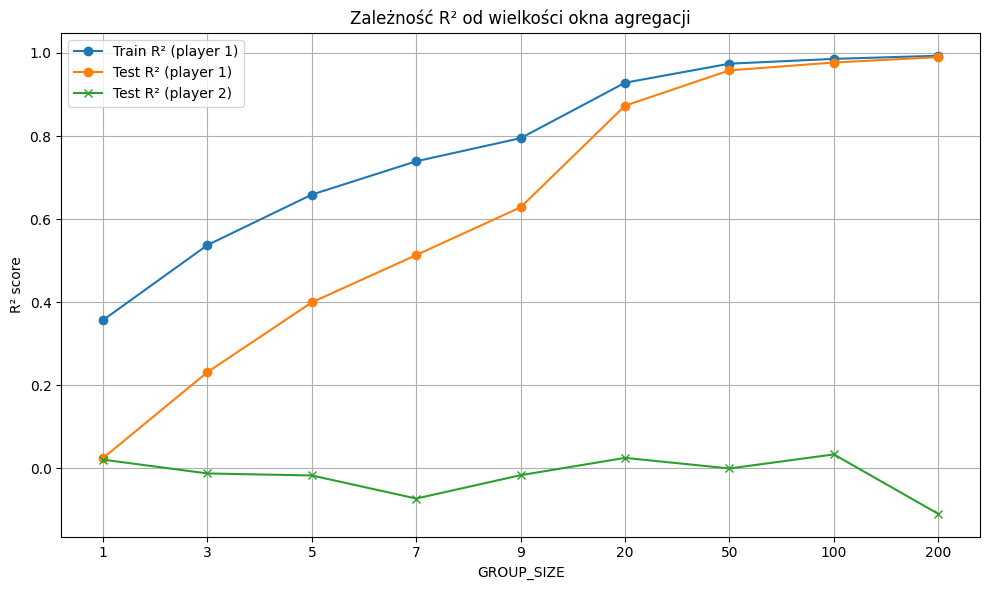

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

MY_USERNAME = "tarask2000"
PGN_FILENAME = "lichess_tarask2000_2025-05-31.pgn"
df = load_games_data(my_username=MY_USERNAME, pgn_filename=PGN_FILENAME)
add_time_cyclic_features(df)

OTHER_USERNAME = "matvij_B"
OTHER_PGN_FILENAME = "lichess_matvij_B_2025-05-31.pgn"
df_other = load_games_data(my_username=OTHER_USERNAME, pgn_filename=OTHER_PGN_FILENAME)
add_time_cyclic_features(df_other)

categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

df_encoded, encoded_cat_df = encode_features(df, categorical_columns)
df_encoded_other, encoded_cat_df_other = encode_features(df_other, categorical_columns)

group_sizes = [1, 3, 5, 7, 9, 20, 50, 100, 200]
train_r2_scores = []
test_r2_scores_1 = []
test_r2_scores_2 = []

onehot_feature_names = list(encoded_cat_df.columns)

for group_size in group_sizes:
    df_grouped_1 = aggregate_windows(df_encoded, group_size)
    df_grouped_1 = df_grouped_1.sample(frac=1, random_state=42).reset_index(drop=True)
    features_1 = df_grouped_1.drop(columns=['total_result'])
    target_1 = df_grouped_1['total_result']

    df_grouped_2 = aggregate_windows(df_encoded_other, group_size)
    df_grouped_2 = df_grouped_2.sample(frac=1, random_state=42).reset_index(drop=True)
    features_2 = df_grouped_2.drop(columns=['total_result'])
    target_2 = df_grouped_2['total_result']

    features_2 = align_columns(features_2, features_1.columns)

    scaling_columns = [col for col in features_1.columns if col not in onehot_feature_names]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), scaling_columns)
        ],
        remainder='passthrough'
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', CatBoostRegressor(verbose=0, random_state=42))
    ])

    X_train, X_test, y_train, y_test = train_test_split(features_1, target_1, test_size=0.2, random_state=0)

    pipeline.fit(X_train, y_train)

    y_train_pred = pipeline.predict(X_train)
    y_test_pred_1 = pipeline.predict(X_test)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2_1 = r2_score(y_test, y_test_pred_1)

    y_test_pred_2 = pipeline.predict(features_2)
    test_r2_2 = r2_score(target_2, y_test_pred_2)

    train_r2_scores.append(train_r2)
    test_r2_scores_1.append(test_r2_1)
    test_r2_scores_2.append(test_r2_2)

plt.figure(figsize=(10, 6))
plt.plot([str(g) for g in group_sizes], train_r2_scores, label='Train R² (player 1)', marker='o')
plt.plot([str(g) for g in group_sizes], test_r2_scores_1, label='Test R² (player 1)', marker='o')
plt.plot([str(g) for g in group_sizes], test_r2_scores_2, label='Test R² (player 2)', marker='x')
plt.title("Zależność R² od wielkości okna agregacji")
plt.xlabel("GROUP_SIZE")
plt.ylabel("R² score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Analiza wyników pokazuje, że wraz ze wzrostem rozmiaru grupy `GROUP_SIZE` wartość współczynnika determinacji R² rośnie. Oznacza to, że model lepiej przewiduje łączny wynik większych serii partii, ponieważ większe grupy redukują wpływ losowości pojedynczych rozgrywek i pozwalają wydobyć stabilniejsze wzorce w danych.

Jednak przy zastosowaniu modelu wyuczonego na danych pierwszego zawodnika do predykcji wyników drugiego zawodnika, R² pozostaje bliskie zeru niezależnie od rozmiaru grupy. To jest pozytywne, ponieważ celem nie było uogólnianie modelu na wszystkich zawodników, lecz identyfikacja indywidualnych mocnych i słabych stron konkretnego gracza.

Wnioski wyciągnięte z modelu są zatem wiarygodne i specyficzne dla analizowanego zawodnika, co pozwala na precyzyjne poznanie jego stylu gry i obszarów do poprawy.


Najważniejsze cechy według modelu CatBoost:
num__rating_diff: 27.973
num__base_time: 3.575
weekday_Saturday: 3.483
opponent_title_WIM: 3.245
weekday_Tuesday: 2.912
opening_Irregular: 2.666
opening_Dutch: 2.421
opening_Sicilian: 2.321
opening_English: 2.270
opening_Catalan: 2.256

SHAP values dla pierwszych 3 przykładów testowych:

Przykład 1: (Prawdziwa wartość: 60.000)


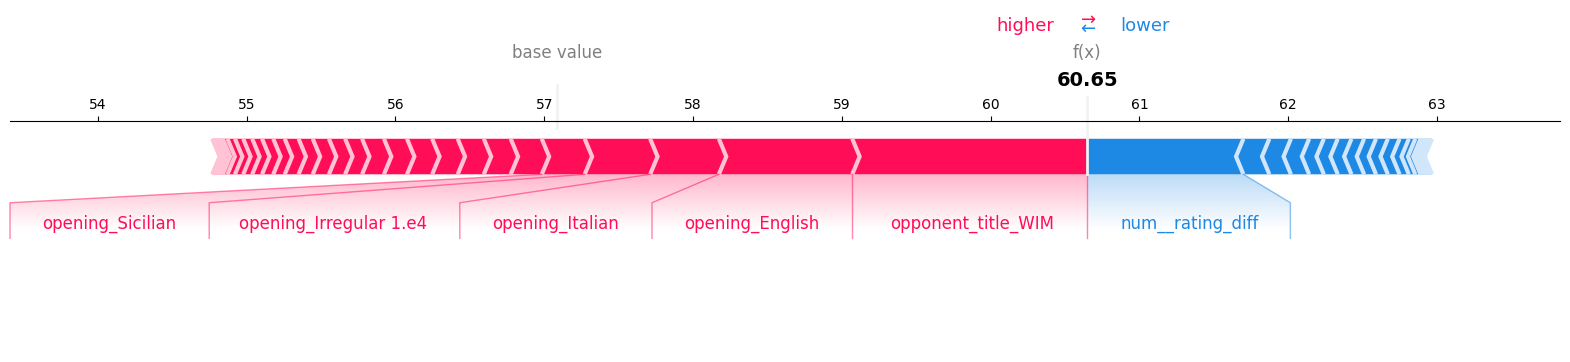


Przykład 2: (Prawdziwa wartość: 61.500)


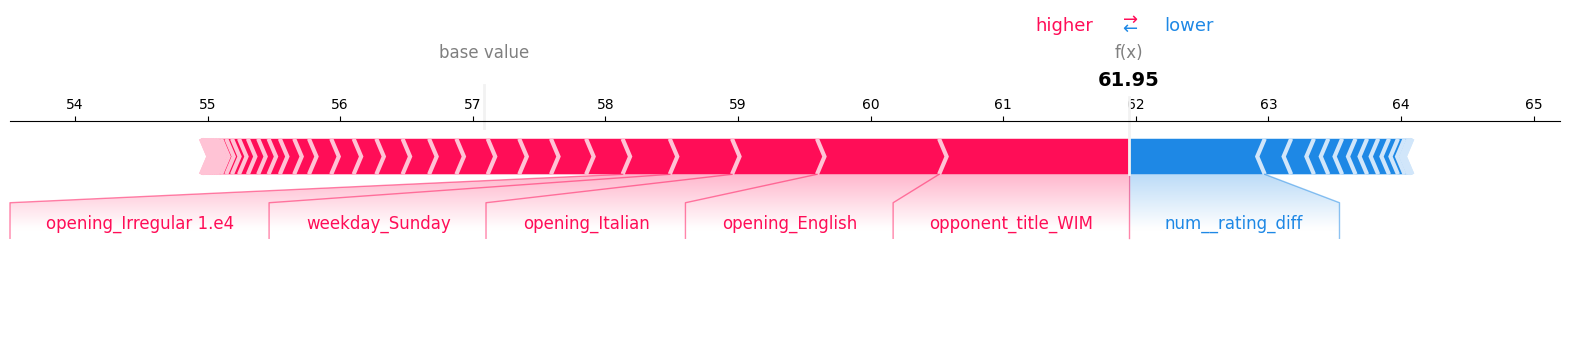


Przykład 3: (Prawdziwa wartość: 65.000)


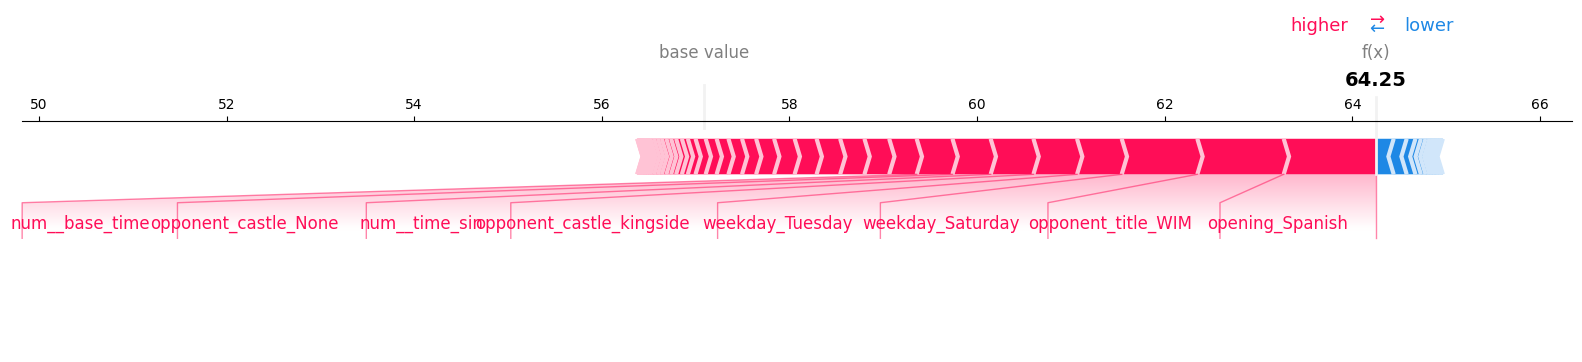

In [35]:
from catboost import Pool
import shap

GROUP_SIZE = 100

df_encoded, encoded_cat_df = encode_features(df, categorical_columns)

df_grouped = aggregate_windows(df_encoded, GROUP_SIZE)
df_grouped = df_grouped.sample(frac=1, random_state=0).reset_index(drop=True)

features = df_grouped.drop(columns=['total_result'])
target = df_grouped['total_result']

onehot_feature_names = list(encoded_cat_df.columns)
scaling_columns = [col for col in features.columns if col not in onehot_feature_names]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), scaling_columns)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(verbose=0, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

cat_model = pipeline.named_steps['regressor']
preprocessor_fitted = pipeline.named_steps['preprocessor']

num_features_scaled = [f'num__{col}' for col in scaling_columns]
feature_names = num_features_scaled + onehot_feature_names

importances = cat_model.get_feature_importance()
feat_imp = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

print("\nNajważniejsze cechy według modelu CatBoost:")
for feat, imp in feat_imp[:10]:
    print(f"{feat}: {imp:.3f}")

X_test_transformed = preprocessor_fitted.transform(X_test)
pool_test = Pool(X_test_transformed, label=y_test)

explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(pool_test)

print("\nSHAP values dla pierwszych 3 przykładów testowych:")

for i in range(3):
    print(f"\nPrzykład {i+1}: (Prawdziwa wartość: {y_test.iloc[i]:.3f})")
    shap.force_plot(
        explainer.expected_value,
        shap_values[i],
        feature_names=feature_names,
        matplotlib=True,
        show=True
    )

# 5. Wnioski

Traktowanie wyniku jako zmiennej kategorycznej lub ciągłej nie przyniosło znaczącej różnicy w skuteczności modelu. Wynika to z faktu, że wynik partii szachowej nie zależy jednoznacznie od pojedynczego czynnika, lecz jest efektem złożonej interakcji wielu elementów gry. W praktyce, wynik jest bardziej oczekiwaną wartością uśrednioną po wielu partiach, a nie deterministyczną wartością zależną od konkretnego parametru.

Dzięki zastosowaniu okien czasowych o odpowiednio dużym rozmiarze udało się wytrenować model, który wychwytuje cechy charakterystyczne dla indywidualnego zawodnika. Model ten uczy się rozpoznawać jego unikalny styl gry, mocne strony oraz słabości, czyli osobiste wzorce i preferencje. To podejście jest bardziej skuteczne niż próba uogólnienia wyniku na podstawie pojedynczych partii czy cech.

W efekcie, analiza danych zagregowanych w większych oknach pozwala na dokładniejsze modelowanie profilu gracza i przewidywanie jego wyników na podstawie charakterystycznych cech, które są stałe dla danej osoby. To potwierdza, że najlepsze rezultaty osiąga się, gdy skupiamy się na specyfice konkretnego zawodnika, a nie na ogólnych wzorcach występujących u różnych graczy.